# Load Standard Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

!pip install pmdarima --quiet
import pmdarima as pmdarima

In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, classification_report, confusion_matrix,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer




# Predicting Market Growth

<h4 style="color:white; background-color:orange">
<abbr title = "Auto Regressive Integrated Moving Average"> ARIMA </abbr> are often good start and well suited as a baseline model in any time series problem.
<ul>
    <li>AR (p) determine the number of lagged series , p =0 means White noise</li>
    <li> MA (q) number of lagged forecasting error terms in the prediction i.e probability + statistics, as we are adjusting our forecast based on previous white noise terms.
</ul>
</h4>




# Functions used throughout the project

In [28]:
def finetune_ARIMA(df, feature_name):
  '''
  Output: Best parameters to build ARIMA Model
  '''

  timeseries_data = df[feature_name]
  # define the range of AR(p) and MA (q)
  start_p = 1
  start_q = 1

  # define the maximum value for AR and MA
  max_p = 3
  max_q = 3

  # define the method to determine the differencing order
  differencing_order = 'adf'

  # define the frequency of the series (no seasonality)
  frequency = 1

  # define whether to consider seasonal components
  seasonal = False

  # define whether to print diagnostic output during the fitting process
  trace = True

  # define how errors during the model should be handled
  error_action = "warn"

  # Define whether to suppress warnings during model fitting
  suppress_warnings = True

  # define whether to use stepwise approach to search for best model parameters
  stepwise = True

  arima_model = pmdarima.auto_arima(timeseries_data,
                                    start_p = start_p,
                                    start_q = start_q,
                                    test = differencing_order,
                                    max_p = max_p,
                                    max_q = max_q,
                                    m = frequency,
                                    d = None,
                                    seasonal = seasonal,
                                    trace= trace,
                                    error_action= error_action,
                                    suppress_warnings=suppress_warnings,
                                    stepwise = stepwise)
  return arima_model


def forecast(arima_model, time_series_data, forecast_periods = 24):
  '''
  Plot the forecasted values along with the confidence intervals using ARIMA model

  Parameters:
  - arima_model : Fitted ARIMA model object
  - time_series_data : Time series data used for training the ARIMA model
  - forecast_periods : Number of periods to forecast into the future(default is 24)
  '''

  # Forecast
  forecast_values, confidence_intervals = arima_model.predict(n_periods = forecast_periods,return_conf_int= True)
  # print("Forecast Values Length:", len(forecast_values))  # Debugging statement

  # Generate index for forecasted values
  forecast_index = pd.date_range(time_series_data.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS') # MonthStart
  # print("Forecast Index Length:", len(forecast_index))  # Debugging statement

  # Create series for plotting
  forecast_series = pd.Series(forecast_values, index = forecast_index)
  lower_confidence_series = pd.Series(confidence_intervals[:,0], index = forecast_index) # confidence_intervals is returned by predicted method
  upper_confidence_series = pd.Series(confidence_intervals[:,1], index = forecast_index)

  # Plot
  plt.figure(figsize=(15,7))
  plt.plot(time_series_data, label="Actual Data", color="gray")
  plt.plot(forecast_series, label="Forecasted Data", color="darkgreen")
  plt.fill(forecast_index, lower_confidence_series,upper_confidence_series,color='k', alpha=.15, label='Confidence Interval' )

  # Add labels and title
  plt.title("ARIMA Model Forecast")
  plt.xlabel("Time")
  plt.ylabel("Values")
  plt.legend()
  plt.show()

def finetune_SARIMA(df, feature_name):
  '''
  Output: Best parameters to build ARIMA Model
  '''

  timeseries_data = df[feature_name]
  # define the range of AR(p) and MA (q)
  start_p = 1
  start_q = 1

  # define the maximum value for AR and MA
  max_p = 3
  max_q = 3

  # define the range of seasonal AR(P) and MA(Q) parameters
  start_P = 1
  max_P = 3
  max_Q = 3

  # define the method to determine the differencing order
  differencing_order = 'adf'

  # define seasonaly differencing order
  seasonal_differencing_order = 1

  # define the frequency of the series (seasonality)
  frequency = 12

  # define whether to consider seasonal components
  seasonal = True

  # define whether to print diagnostic output during the fitting process
  trace = False

  # define how errors during the model should be handled
  error_action = "ignore"

  # Define whether to suppress warnings during model fitting
  suppress_warnings = True

  # define whether to use stepwise approach to search for best model parameters
  stepwise = True

  sarima_model = pmdarima.auto_arima(timeseries_data,
                                    start_p = start_p,
                                    start_q = start_q,
                                    test = differencing_order,
                                    max_p = max_p,
                                    max_q = max_q,
                                    m = frequency,
                                    d = 0, # None means Let the model determine non-seasonal differencing order
                                    D = seasonal_differencing_order,
                                    seasonal = seasonal,
                                    trace= trace,
                                    error_action= error_action,
                                    suppress_warnings=suppress_warnings,
                                    stepwise = stepwise)
  return sarima_model

def forecast_2(arima_model, time_series_data, forecast_periods=24, overlap_months=5):
  '''
  Plot the forecasted values along with the confidence intervals using ARIMA model
  This function allows you to specify an overlap period between the forecast and the existing data, while the previous version starts the forecast immediately after the last observed data point.

  Parameters:
    - arima_model : Fitted ARIMA model object
    - time_series_data : Time series data used for training the ARIMA model
    - forecast_periods : Number of periods to forecast into the future (default is 24)
    - overlap_months: Number of months to overlap with existing data before starting the forecast (default is 5)
    '''
  # convert index to datetime if not already in datetime format
  if not isinstance(time_series_data.index, pd.DatetimeIndex):
    time_series_data.index = pd.to_datetime(time_series_data.index)

  # Forecast
  forecast_values, confidence_intervals = arima_model.predict(n_periods=forecast_periods, return_conf_int=True)

  # Generate index for forecasted values starting from "overlap_months" before the last month in the dataset
  start_index = time_series_data.index[-1] - pd.DateOffset(months=overlap_months)
  forecast_index = pd.date_range(start=start_index, periods=forecast_periods, freq='MS')  # MonthStart

  # Create series for plotting
  forecast_series = pd.Series(forecast_values, index=forecast_index)
  lower_confidence_series = pd.Series(confidence_intervals[:, 0], index=forecast_index)
  upper_confidence_series = pd.Series(confidence_intervals[:, 1], index=forecast_index)

  # Plot
  plt.figure(figsize=(15, 7))
  plt.plot(time_series_data, label="Actual Data", color="gray")
  plt.plot(forecast_series, label="Forecasted Data", color="darkgreen")
  plt.fill_between(forecast_index, lower_confidence_series, upper_confidence_series, color='k', alpha=.15, label='Confidence Interval')

  # Add labels and title
  plt.title("ARIMA Model Forecast")
  plt.xlabel("Time")
  plt.ylabel("Values")
  plt.legend()
  plt.show()


def finetune_SARIMAX(df, feature_name, month_index):
  '''
  Output: Best parameters to build ARIMA Model
  '''

  timeseries_data = df[feature_name]
  #df["month_index"] = df[feature_name].index.month # add month to data

  exogenous = df[month_index]

  # define the range of AR(p) and MA (q)
  start_p = 1
  start_q = 1

  # define the maximum value for AR and MA
  max_p = 3
  max_q = 3

  # define the range of seasonal AR(P) and MA(Q) parameters
  start_P = 1
  max_P = 3
  max_Q = 3

  # define the method to determine the differencing order
  differencing_order = 'adf'

  # define seasonaly differencing order
  seasonal_differencing_order = 1

  # define the frequency of the series (seasonality)
  frequency = 12

  # define whether to consider seasonal components
  seasonal = True

  # define whether to print diagnostic output during the fitting process
  trace = True

  # define how errors during the model should be handled
  error_action = "ignore"

  # Define whether to suppress warnings during model fitting
  suppress_warnings = True

  # define whether to use stepwise approach to search for best model parameters
  stepwise = True

  sarimax_model = pmdarima.auto_arima(timeseries_data,
                                     exogenous = exogenous,
                                    start_p = start_p,
                                    start_q = start_q,
                                    test = differencing_order,
                                    max_p = max_p,
                                    max_q = max_q,
                                    m = frequency,
                                    d = 0, # None means Let the model determine non-seasonal differencing order
                                    D = seasonal_differencing_order,
                                    seasonal = seasonal,
                                    trace= trace,
                                    error_action= error_action,
                                    suppress_warnings=suppress_warnings,
                                    stepwise = stepwise)
  return sarimax_model


def forecast_sarimax(sarimax_model, df, time_series_data, forecast_periods=24, overlap_months=5):
    '''
    Plot the forecasted values along with the confidence intervals using SARIMAX model
    This function allows you to specify an overlap period between the forecast and the existing data,
    while the previous version starts the forecast immediately after the last observed data point.

    Parameters:
    - sarimax_model : Fitted SARIMAX model object
    - df : DataFrame containing the time series data
    - time_series_data : Time series data used for training the SARIMAX model
    - forecast_periods : Number of periods to forecast into the future (default is 24)
    - overlap_months: Number of months to overlap with existing data before starting the forecast (default is 5)
    '''

    # Create DataFrame with month indices for forecast periods
    forecast_df = pd.DataFrame({"month_index": pd.date_range(df.index[-1], periods=forecast_periods, freq='MS').month},
                                index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS'))

    # Forecast
    forecast_values, confidence_intervals = sarimax_model.predict(n_periods=forecast_periods,
                                                                  return_conf_int=True,
                                                                  exogenous=forecast_df[['month_index']])

    # Generate index for forecasted values starting from "overlap_months" before the last month in the dataset
    start_index = time_series_data.index[-1] - pd.DateOffset(months=overlap_months)
    forecast_index = pd.date_range(start=start_index, periods=forecast_periods, freq='MS')  # MonthStart

    # Create series for plotting
    forecast_series = pd.Series(forecast_values, index=forecast_index)
    lower_confidence_series = pd.Series(confidence_intervals[:, 0], index=forecast_index)
    upper_confidence_series = pd.Series(confidence_intervals[:, 1], index=forecast_index)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(time_series_data, label="Actual Data", color="gray")
    plt.plot(forecast_series, label="Forecasted Data", color="darkgreen")
    plt.fill_between(forecast_index, lower_confidence_series, upper_confidence_series, color='k', alpha=.15, label='Confidence Interval')

    # Add labels and title
    plt.title("SARIMAX Model Forecast")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

def finetune_ARIMA_model2(df, feature_name):
    timeseries_data = df[feature_name]

    # Manually specify the differencing order
    d = 1

    arima_model = pmdarima.auto_arima(timeseries_data,
                                       d=d,
                                       seasonal=False,
                                       trace=True,
                                       error_action='ignore',
                                       suppress_warnings=True,
                                       stepwise=True)
    return arima_model

def train_evaluate_models_binaryclass(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    # Process categorical features using OneHotEncoder
    ohe = OneHotEncoder()
    y_train_encoded = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
    y_test_encoded = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

    # Scale numerical features using Standard Scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded

def train_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

     # Get unique class names from original y data
    class_names = np.unique(y)

    # Process categorical features using OneHotEncoder
    ohe = OneHotEncoder()
    y_train_encoded = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
    y_test_encoded = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

    # Convert one-hot encoded labels to 1D array
    y_train_labels = np.argmax(y_train_encoded, axis=1)
    y_test_labels = np.argmax(y_test_encoded, axis=1)

    # Scale numerical features using Standard Scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Print class names for encoded labels
    print("Class categories for encoded labels:", ohe.categories_)
    # Print class names for encoded labels
    print("Class names for encoded labels:",class_names)

    return X_train_scaled, X_test_scaled, y_train_labels, y_test_labels


## Load Data

In [29]:
data_dir = "/content/drive/MyDrive/AI Course with UC Berkely/capstone/"

In [30]:
cleaned_stainlessSteel_df = pd.read_csv(f"{data_dir}cleaned_stainlessSteel.csv")
cleaned_gdp_df = pd.read_csv(f"{data_dir}cleaned_gdp.csv")

In [31]:
economy_df=pd.read_csv(f"{data_dir}economy_data.csv", index_col = 0)

In [32]:
const_market_df=pd.read_csv(f"{data_dir}ByRegionIndustryBuildings.csv", index_col ="Year")

# 1. Stainless Steel Data Forecast

### Set Date as index

In [33]:
cleaned_stainlessSteel_df['Date'] = pd.to_datetime(cleaned_stainlessSteel_df['Date'])

In [34]:
cleaned_stainlessSteel_df.head(2)

,Date,Price USD,Year,Month,Day
0,2010-12-01,100.0,2010,12,12
1,2011-01-01,100.7,2011,1,1


In [35]:
cleaned_stainlessSteel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       134 non-null    datetime64[ns]
 1   Price USD  134 non-null    float64       
 2   Year       134 non-null    int64         
 3   Month      134 non-null    int64         
 4   Day        134 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 5.4 KB


In [36]:
cleaned_stainlessSteel_df.set_index("Date", inplace = True)

In [37]:
cleaned_stainlessSteel_df.head(2)

,Price USD,Year,Month,Day
Date,,,,
2010-12-01,100.0,2010,12,12
2011-01-01,100.7,2011,1,1


In [38]:
cleaned_stainlessSteel_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2010-12-01 to 2022-01-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price USD  134 non-null    float64
 1   Year       134 non-null    int64  
 2   Month      134 non-null    int64  
 3   Day        134 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 5.2 KB


# Build ARIMA

In [39]:
arima_model = finetune_ARIMA(cleaned_stainlessSteel_df, 'Price USD')
arima_model

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=572.068, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=586.095, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=576.733, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=578.159, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=588.988, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=574.057, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=574.048, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=579.896, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=577.452, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=574.754, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=571.428, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=579.502, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=577.511, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=573.411, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=573.3

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

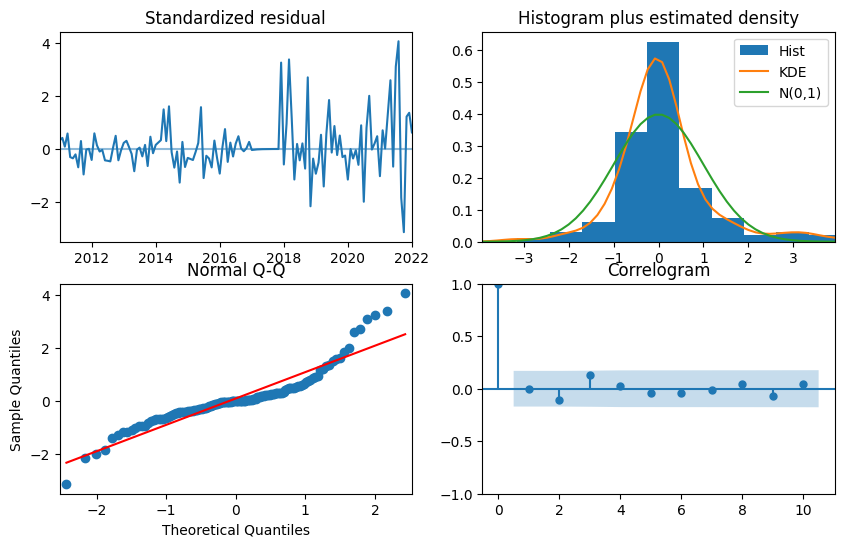

In [40]:
arima_model.plot_diagnostics(figsize=(10,6))
plt.show()

4 plots are created using `plot_diagnostics()` function.

Interpretion:
1. Standardized Residual
  - There are no obvious patterns in the residuals, with values having mean of 0 and having unform variance
2. Histogram plus KDE
 - It looks normally distributed and should be similar to plot N(0,1)
3. Normal Q-Q
 - Most of the data points lie around the line
4. Correlogram (ACF plot)
 - 95% of correlations for lag should not be greater than 0. The gray area is the confidence area and if values falls outside of this, they are statistically significant. In out case. There are 1 valyes outside of this shaded area so we need to add more predictors to  make model accurate

 We will forecast for next 24 months

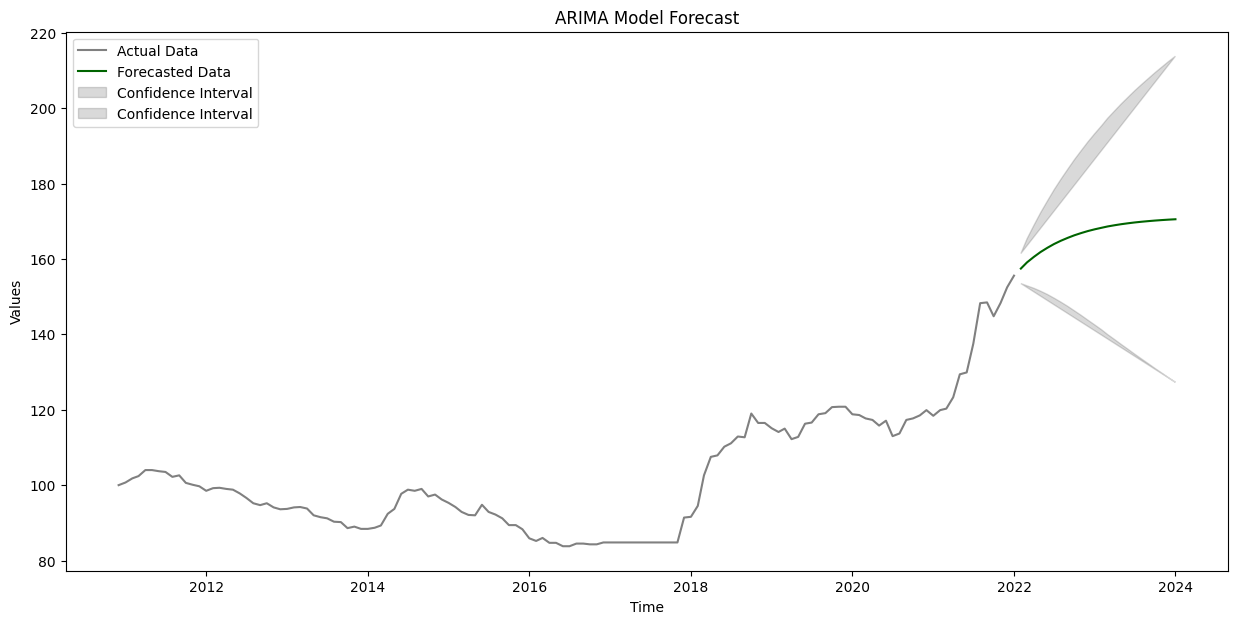

In [41]:
forecast(arima_model,cleaned_stainlessSteel_df['Price USD'])

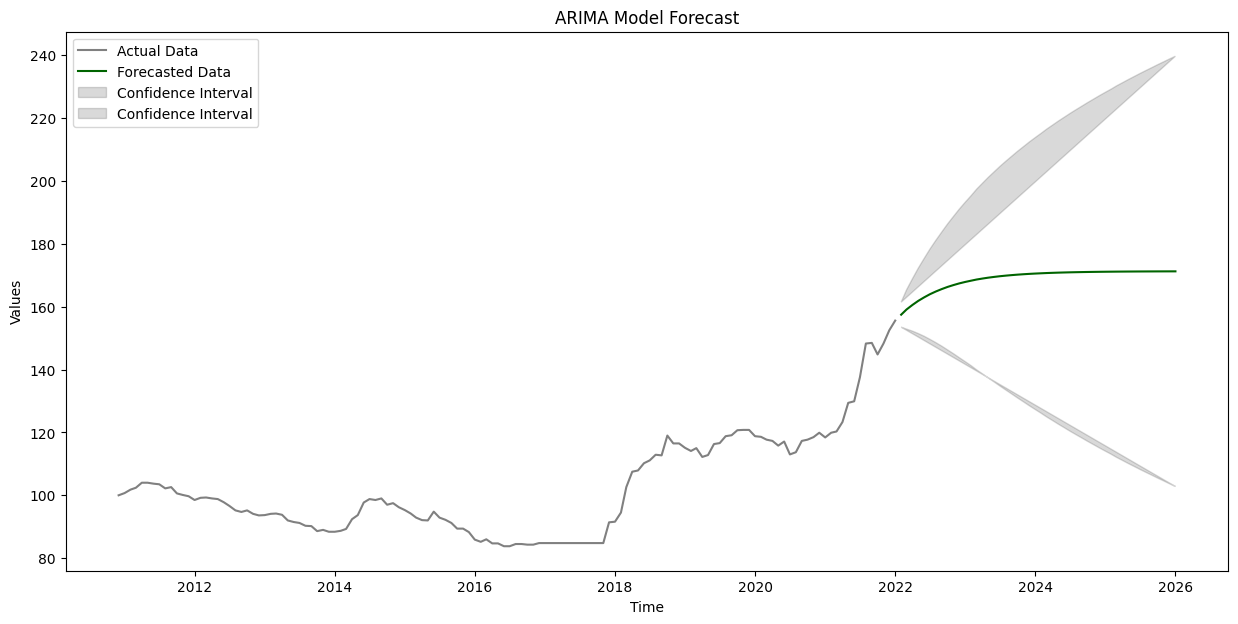

In [42]:
forecast(arima_model,cleaned_stainlessSteel_df['Price USD'],forecast_periods=48)

## SARIMA Model
Now let’s try the same strategy as we did above, except let’s use a SARIMA model so that we can account for seasonality.

In [43]:
sarima_model = finetune_SARIMA(cleaned_stainlessSteel_df, 'Price USD')
sarima_model

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

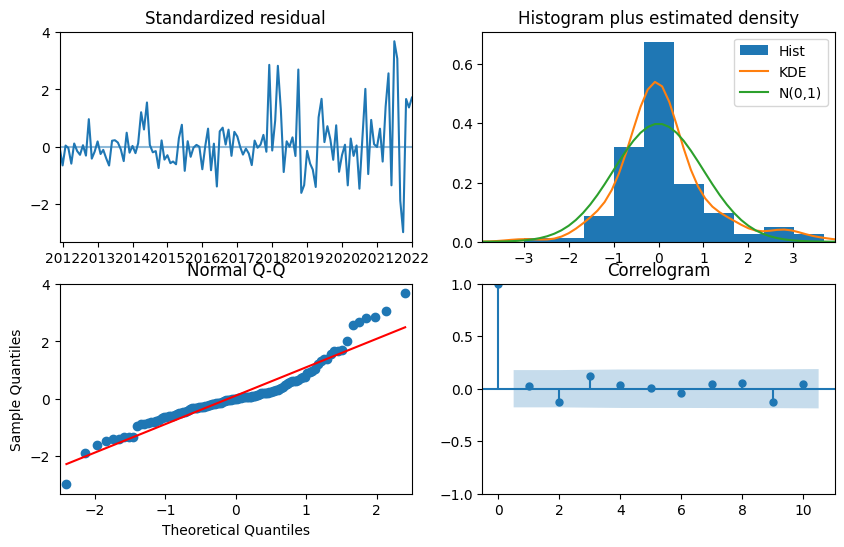

In [44]:
sarima_model.plot_diagnostics(figsize=(10,6))
plt.show()

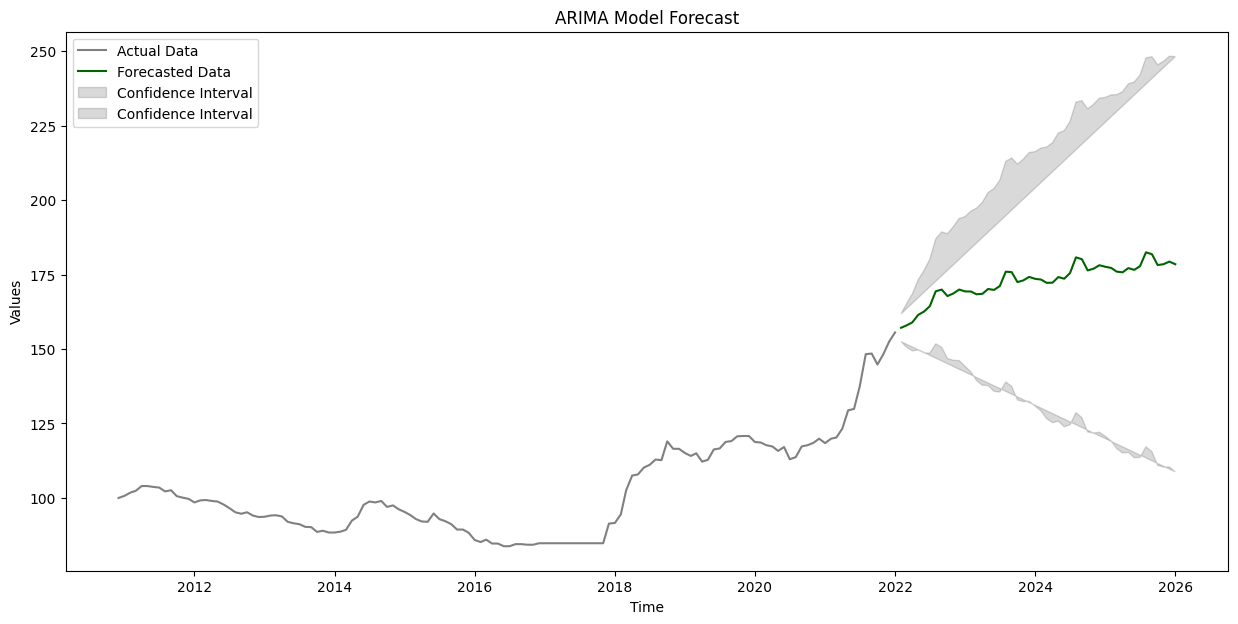

In [45]:
forecast(sarima_model,cleaned_stainlessSteel_df['Price USD'],forecast_periods=48)

SARIMA model seems to be more accurate as width of confidence interval is  following data closely

# SARIMAX Model Selection

In this, we will add the month number as exogenous variable, but this is not super useful as this is already conveyed through seasonality

In [46]:
sarimax_model = finetune_SARIMAX(cleaned_stainlessSteel_df, "Price USD", "Month")
sarimax_model

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=951.016, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=595.534, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=812.752, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=959.683, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=610.445, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=952.846, Time=0.34 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=583.831, Time=0.56 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=595.975, Time=0.43 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=579.510, Time=1.44 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

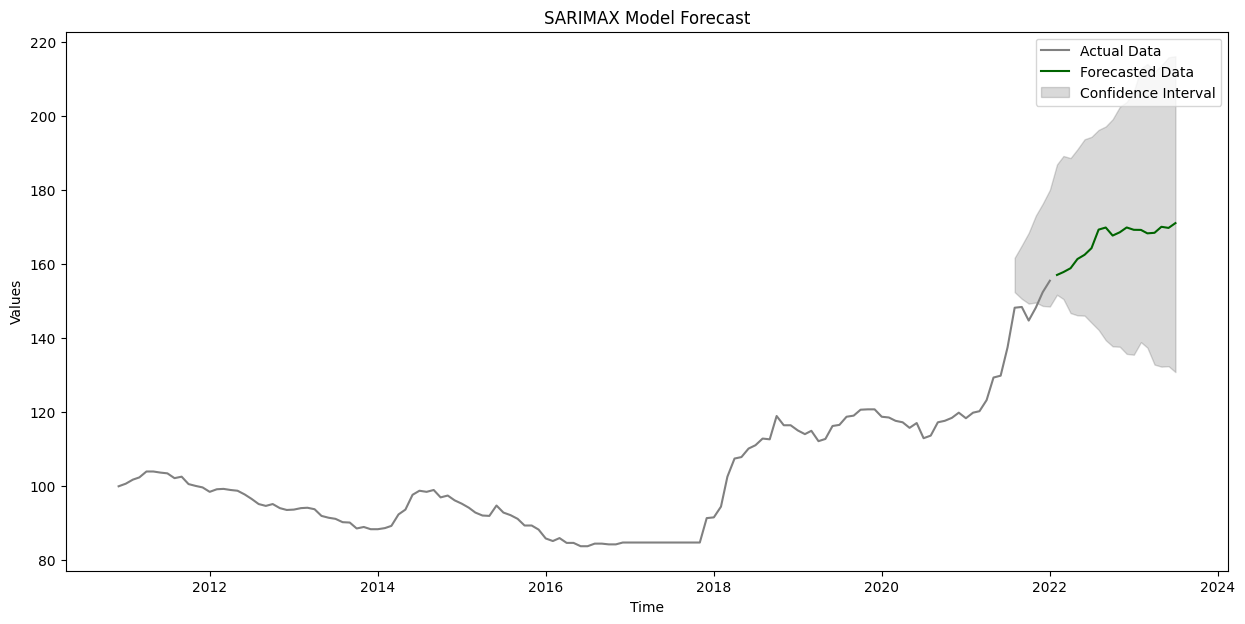

In [47]:
forecast_sarimax(sarimax_model, cleaned_stainlessSteel_df, cleaned_stainlessSteel_df["Price USD"])


Confidence interval has shrinked so it is better

## Economy data

In [48]:
economy_df.head(3)

,Date,Stainless Steel Price USD,Year,Month,Day,Economy_Status
0,2010-12-01,100.0,2010.0,12.0,12.0,Bullish
1,2011-01-01,100.7,2011.0,1.0,1.0,Bullish
2,2011-02-01,101.8,2011.0,2.0,2.0,Bullish


In [49]:
# economy_df.drop(columns=["Time"], inplace=True)

In [50]:
economy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 0 to 132
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       133 non-null    object 
 1   Stainless Steel Price USD  133 non-null    float64
 2   Year                       133 non-null    float64
 3   Month                      133 non-null    float64
 4   Day                        133 non-null    float64
 5   Economy_Status             133 non-null    object 
dtypes: float64(4), object(2)
memory usage: 11.3+ KB


In [51]:
# Convert 'Date' to datetime
economy_df['Date'] = pd.to_datetime(economy_df['Date'])

Split the data into features and target

In [52]:
economy_df['Economy_Status'].unique()

array(['Bullish', 'Neutral', 'Bearish'], dtype=object)

In [53]:
X = economy_df.drop(labels=['Economy_Status','Date'], axis = 1 )
y = economy_df["Economy_Status"]

Define train and test

 We will use One Hot Encoding as Label encoding can inadvertently introduce a false sense of order, which could lead the model to interpret the data incorrectly.

y_train: it's a 1D array containing the target labels. By reshaping it to a 2D array using .reshape(-1, 1), we're essentially converting it from a single column to a single-column matrix. This is necessary because OneHotEncoder requires a 2D array input.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training and evaluation

### Logistic Regression

In [58]:
def log_reg(X_train_scaled, y_train, X_test_scaled, y_test):
    # Instantiate the model
    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

    # Fit data
    lr.fit(X_train_scaled, y_train)

    # Predict
    y_predict = lr.predict(X_test_scaled)

    performance = {}

    # Measure model performance
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_predict, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test_scaled), average='weighted', multi_class='ovr')
    f1 = f1_score(y_test, y_predict, average='weighted', zero_division=0)
    confusion = confusion_matrix(y_test, y_predict)

    # Class names corresponding to encoded labels
    class_names = ['Bearish', 'Bullish', 'Neutral']  # Replace with your class names

    performance["metrics"] = pd.DataFrame({
        "Accuracy Score": accuracy,
        "Precision Score": precision,
        "Recall Score": recall,
        "ROC-AUC Score": roc_auc,
        "F1 Score": f1
    }, index=[0])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Set y ticks to class names
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)

    plt.show()

    return performance


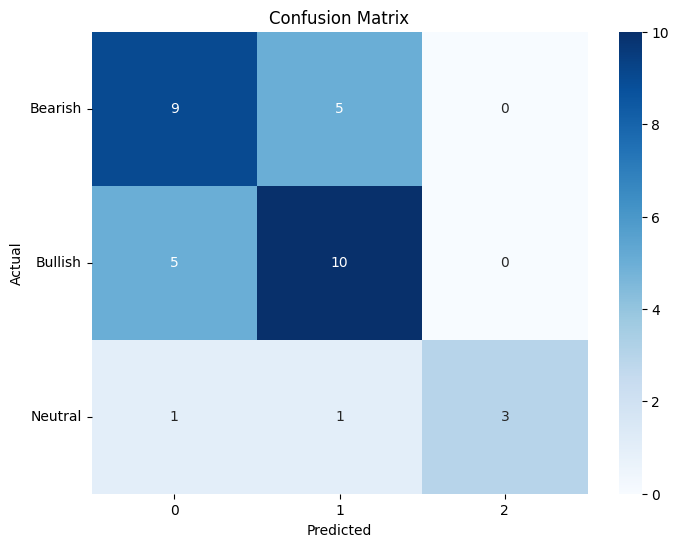

{'metrics':    Accuracy Score  Precision Score  Recall Score  ROC-AUC Score  F1 Score
 0        0.647059         0.669853      0.647059       0.718493  0.650502}

In [59]:
log_reg(X_train, y_train, X_test, y_test)

### With Scaling and One Hot Encoding applied on X and y

In [60]:
X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded = train_evaluate_models(X, y)

Class categories for encoded labels: [array(['Bearish', 'Bullish', 'Neutral'], dtype=object)]
Class names for encoded labels: ['Bearish' 'Bullish' 'Neutral']


In [61]:
class_names = np.unique(y)
# Assume class_names contains the unique class names (e.g., ['bearish', 'bullish', 'neutral'])
class_mapping = {i: class_name for i, class_name in enumerate(class_names)}

# Then, you can access the class name for an encoded value like this:
# encoded_value = 0
# class_name = class_mapping[encoded_value]  # This will give you 'bearish'
class_mapping

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

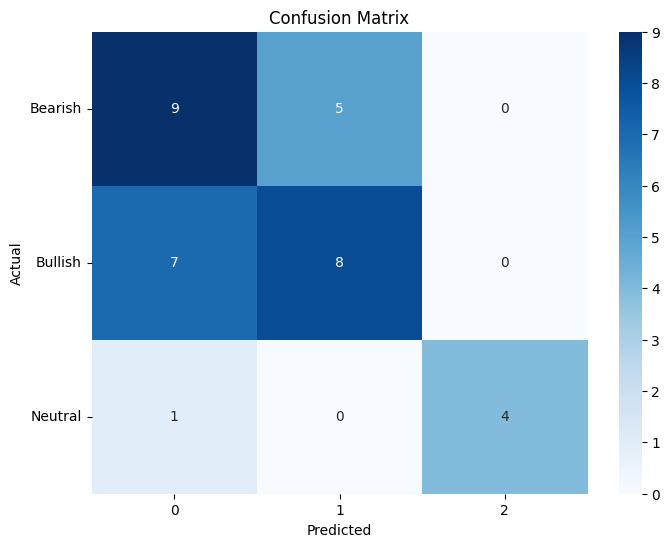

{'metrics':    Accuracy Score  Precision Score  Recall Score  ROC-AUC Score  F1 Score
 0        0.617647         0.636545      0.617647       0.694366  0.621909}

In [62]:
log_reg(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded)

In [63]:
def evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, class_names):
    # Fit data
    model.fit(X_train_scaled, y_train)

    # Predict
    y_predict = model.predict(X_test_scaled)

    performance = {}

    # Measure model performance
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_predict, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled), average='weighted', multi_class='ovr')
    f1 = f1_score(y_test, y_predict, average='weighted', zero_division=0)
    confusion = confusion_matrix(y_test, y_predict)

    performance["metrics"] = pd.DataFrame({
        "Accuracy Score": accuracy,
        "Precision Score": precision,
        "Recall Score": recall,
        "ROC-AUC Score": roc_auc,
        "F1 Score": f1
    }, index=[0])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Set y ticks to class names
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)

    plt.show()

    return performance


In [64]:
# Define models
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
random_forest_model = RandomForestClassifier()
gradient_boosting_model = GradientBoostingClassifier()
knn_model = KNeighborsClassifier()

Model: LogisticRegression


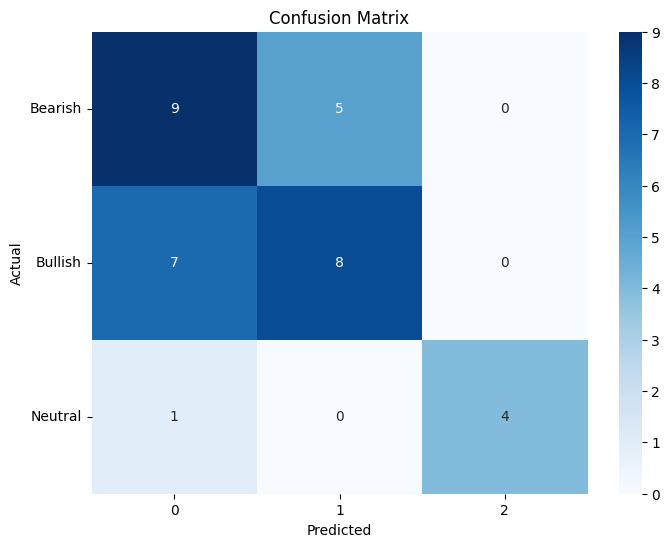

Performance Metrics:
   Accuracy Score  Precision Score  Recall Score  ROC-AUC Score  F1 Score
0        0.617647         0.636545      0.617647       0.694366  0.621909


Model: RandomForestClassifier


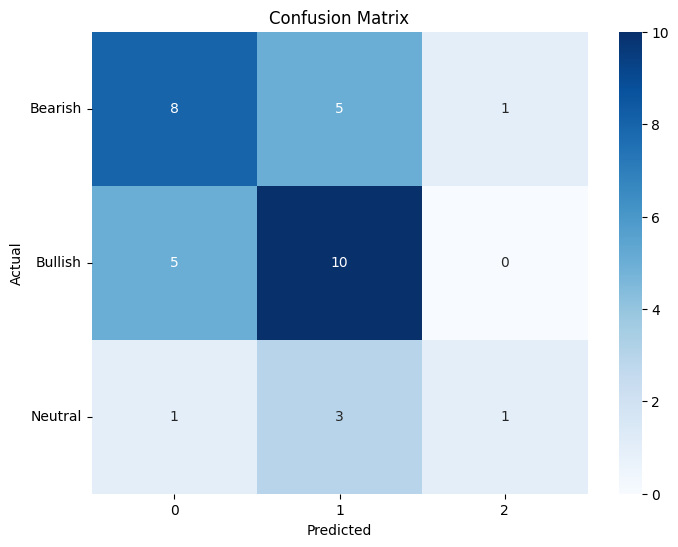

Performance Metrics:
   Accuracy Score  Precision Score  Recall Score  ROC-AUC Score  F1 Score
0        0.558824         0.553922      0.558824       0.670236  0.544691


Model: GradientBoostingClassifier


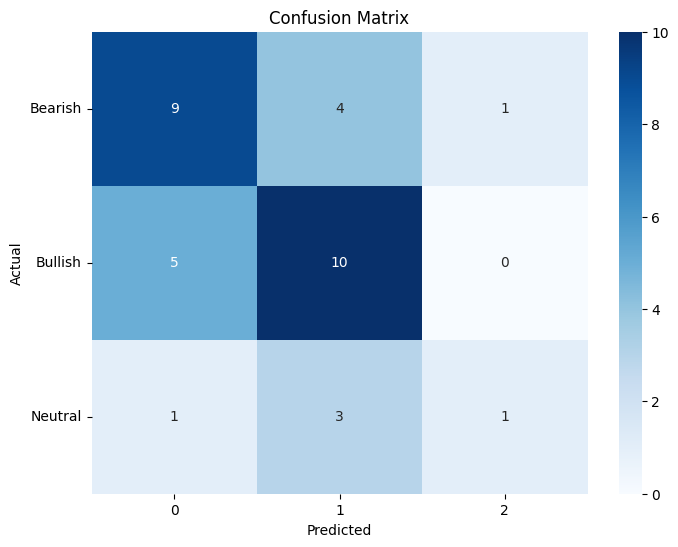

Performance Metrics:
   Accuracy Score  Precision Score  Recall Score  ROC-AUC Score  F1 Score
0        0.588235         0.580104      0.588235        0.63278   0.57333


Model: KNeighborsClassifier


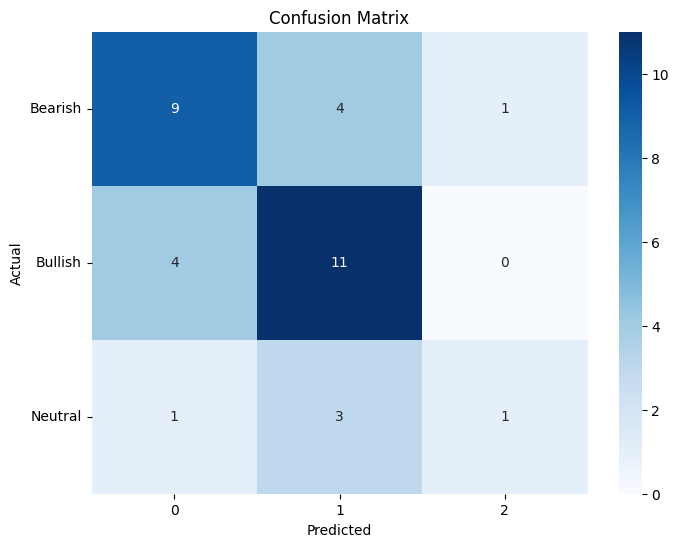

Performance Metrics:
   Accuracy Score  Precision Score  Recall Score  ROC-AUC Score  F1 Score
0        0.617647         0.607843      0.617647       0.667578   0.60084




In [65]:
# List of models
models = [logistic_model, random_forest_model, gradient_boosting_model, knn_model]

# Iterate over models and evaluate each one
for model in models:
    print("Model:", model.__class__.__name__)
    performance = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, class_names=['Bearish', 'Bullish', 'Neutral'])
    print("Performance Metrics:")
    print(performance["metrics"])
    print("\n")

## Construction Market Modelling

In [66]:
const_market_df.tail(3)

,Unnamed: 0,Region,IndustrySegment,Buildings,SAREA,SUNITS,SVAL00,Measure,SALTV,SNAVAL,YEARQTR
Year,,,,,,,,,,,
2028,30885,West South Central,Residential,One-family Houses,602838.13689,240393.37640,40040964,6.535573e+07,0.0,0.0,2028:2
2028,30886,West South Central,Residential,One-family Houses,606083.32578,241451.16992,40256512,6.610327e+07,0.0,0.0,2028:3
2028,30887,West South Central,Residential,One-family Houses,603905.98407,240365.46674,40111892,6.625702e+07,0.0,0.0,2028:4


In [67]:
const_market_df.drop(columns=['Unnamed: 0','YEARQTR'], inplace=True)

In [68]:
const_market_df_updated = pd.get_dummies(const_market_df, dtype=int)

In [69]:
# Data transformation (One Hot Encoding)
const_market_df_updated.head(2)

,SAREA,SUNITS,SVAL00,Measure,SALTV,SNAVAL,Region_East North Central,Region_East South Central,Region_Middle Atlantic,Region_New England,...,Buildings_Other Nonbuilding,Buildings_Parking Garages and Automotive Services,Buildings_Power Plants/Gas/Communications,Buildings_Religious Buildings,"Buildings_Schools, Libraries, and Labs (nonmfg)",Buildings_Sewerage and Waste Disposal Systems,Buildings_Stores and Restaurants,Buildings_Streets and Highways,Buildings_Warehouses (excl. manufacturer owned),Buildings_Water Supply Systems
Year,,,,,,,,,,,,,,,,,,,,,
2020,0.0,0.0,1285740,2.654043e+06,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020,0.0,0.0,1297001,2.671935e+06,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Define X and y
X = const_market_df_updated.drop(columns=['Measure'])
y = const_market_df_updated['Measure']

In [71]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Define models
linearReg_model = LinearRegression()
random_forest_model = RandomForestRegressor()
gradient_boosting_model = GradientBoostingRegressor()
knn_model = KNeighborsRegressor()

In [73]:
# List of models as it is a regression problem
models = [linearReg_model, random_forest_model, gradient_boosting_model, knn_model]

In [74]:
def pred_models(model, X_train, y_train, X_test, y_test):
    # Fit data
    model.fit(X_train, y_train)

    # Predict
    y_predict = model.predict(X_test)

    performance = {}

    # Measure model performance
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predict)

    performance = pd.DataFrame({
        "Model": model.__class__.__name__,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }, index=[0])

    sns.lineplot(x=range(len(y_test)), y=y_test, label='Actual')
    sns.lineplot(x=range(len(y_test)), y=y_predict, label='Predicted')

    plt.show()

    return performance


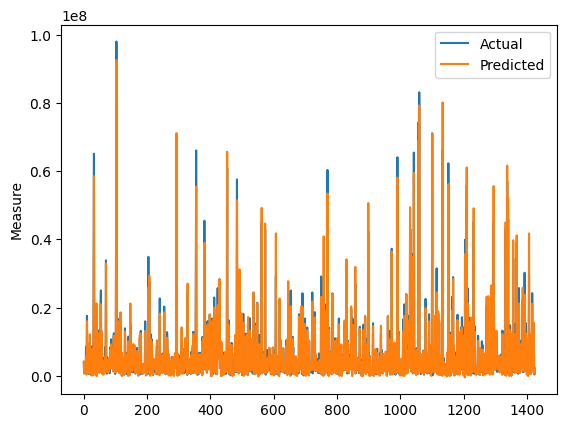

              Model           MSE          RMSE  R2 Score
0  LinearRegression  2.379263e+12  1.542486e+06  0.973127


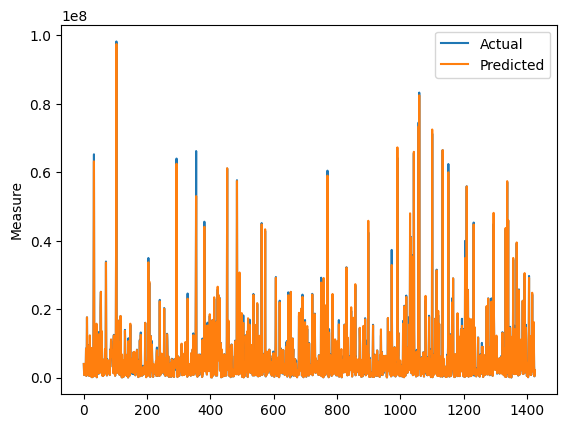

                   Model           MSE           RMSE  R2 Score
0  RandomForestRegressor  4.457183e+11  667621.391439  0.994966


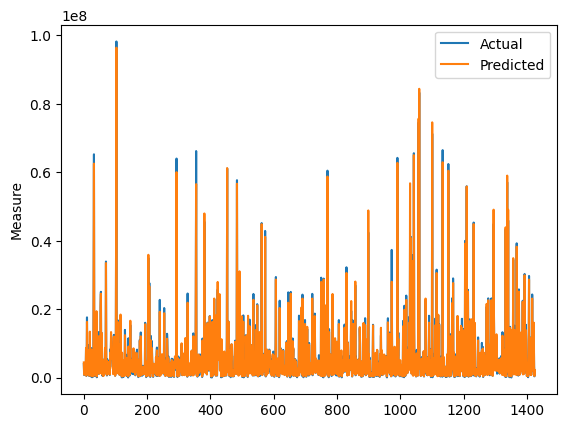

                       Model           MSE           RMSE  R2 Score
0  GradientBoostingRegressor  8.656159e+11  930384.800599  0.990223


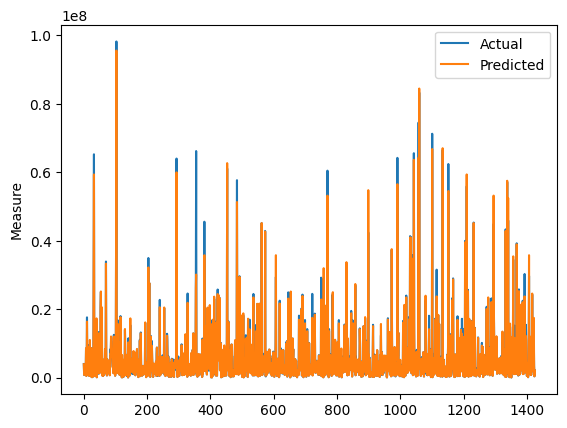

                 Model           MSE          RMSE  R2 Score
0  KNeighborsRegressor  2.374458e+12  1.540928e+06  0.973181


In [75]:
for model in models:
  results = pred_models(model,X_train, y_train, X_test, y_test)
  # print("Model:", model.__class__.__name__)
  print(results)

- For all models, the R2 scores are quite high, indicating that the models explain a significant portion of the variance in the target variable.
- The RandomForestRegressor model has the lowest MSE and RMSE among all models, suggesting that it has the best performance in terms of minimizing the squared differences between actual and predicted values.


In [85]:
forecast = pd.DataFrame(
{    "Actual Test": y_test,
    "Predicted": y_predict}
)

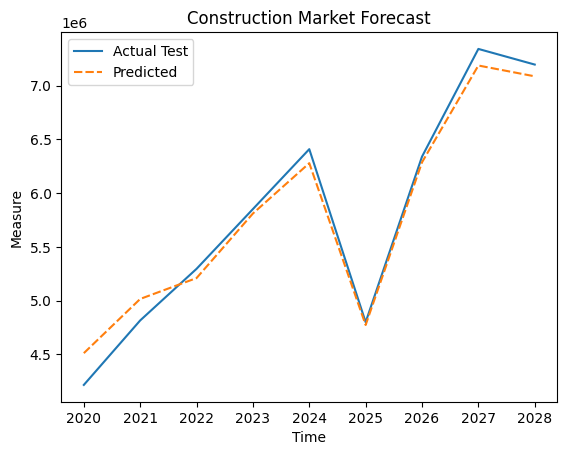

In [86]:
sns.lineplot(data=forecast, errorbar=None)
plt.title("Construction Market Forecast")
plt.xlabel("Time")
plt.ylabel("Measure")
plt.show()

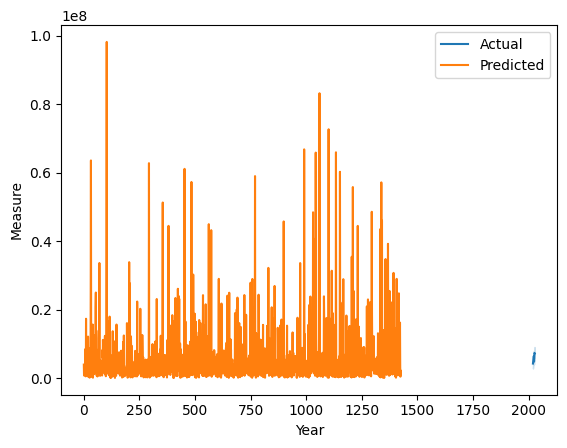

In [78]:
model = RandomForestRegressor()

# Fit data
model.fit(X_train, y_train)

# Predict
y_predict = model.predict(X_test)

sns.lineplot(y_test, label='Actual')
sns.lineplot(y_predict, label='Predicted')

plt.show()



## Forecast on each Segment of Market

In [79]:
const_market_df_updated.tail(3)

,SAREA,SUNITS,SVAL00,Measure,SALTV,SNAVAL,Region_East North Central,Region_East South Central,Region_Middle Atlantic,Region_New England,...,Buildings_Other Nonbuilding,Buildings_Parking Garages and Automotive Services,Buildings_Power Plants/Gas/Communications,Buildings_Religious Buildings,"Buildings_Schools, Libraries, and Labs (nonmfg)",Buildings_Sewerage and Waste Disposal Systems,Buildings_Stores and Restaurants,Buildings_Streets and Highways,Buildings_Warehouses (excl. manufacturer owned),Buildings_Water Supply Systems
Year,,,,,,,,,,,,,,,,,,,,,
2028,602838.13689,240393.37640,40040964,6.535573e+07,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2028,606083.32578,241451.16992,40256512,6.610327e+07,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2028,603905.98407,240365.46674,40111892,6.625702e+07,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
const_market_df_updated.columns

Index(['SAREA', 'SUNITS', 'SVAL00', 'Measure', 'SALTV', 'SNAVAL',
       'Region_East North Central', 'Region_East South Central',
       'Region_Middle Atlantic', 'Region_New England',
       'Region_Pacific Northwest', 'Region_Pacific Southwest',
       'Region_South Atlantic', 'Region_West North Central',
       'Region_West South Central', 'IndustrySegment_Nonbuilding',
       'IndustrySegment_Nonresidential', 'IndustrySegment_Residential',
       'Buildings_Amusement, Social and Recreational Bldgs',
       'Buildings_Apartments and Two-family houses', 'Buildings_Bridges',
       'Buildings_Dams/Reservoirs/River Development', 'Buildings_Dormitories',
       'Buildings_Government Service Buildings',
       'Buildings_Hospitals and Other Health Treatment',
       'Buildings_Hotels and Motels',
       'Buildings_Manufacturing Plants, Warehouses, Labs',
       'Buildings_Miscellaneous Nonresidential Buildings',
       'Buildings_Office and Bank Buildings', 'Buildings_One-family Houses'

In [81]:
def prepare_data(search_term):
    # filter data
    X = const_market_df_updated.filter(like=search_term)
    y = const_market_df_updated['Measure']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

def eval_model(model):
  model = RandomForestRegressor()

  # Fit data
  model.fit(X_train, y_train)

  # Predict
  y_predict = model.predict(X_test)

  # Measure model performance
  mse = mean_squared_error(y_test, y_predict)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_predict)

  performance = pd.DataFrame({
        "Model": model.__class__.__name__,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }, index=[0])

  sns.lineplot(y_test, label='Actual')
  sns.lineplot(y_predict, label='Predicted')

  plt.show()

  return performance

def main(search_term, model):
  X_train, X_test, y_train, y_test = prepare_data(search_term)
  print(f"Model for {search_term}")
  performance = eval_model(model)
  print(performance)

Model for Region


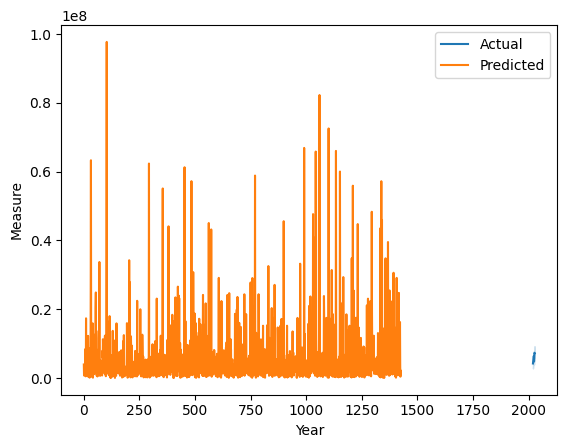

                   Model           MSE           RMSE  R2 Score
0  RandomForestRegressor  3.954938e+11  628882.968936  0.995533


In [82]:
search_term = "Region"
model = RandomForestRegressor()
main(search_term,model)

Model for IndustrySegment


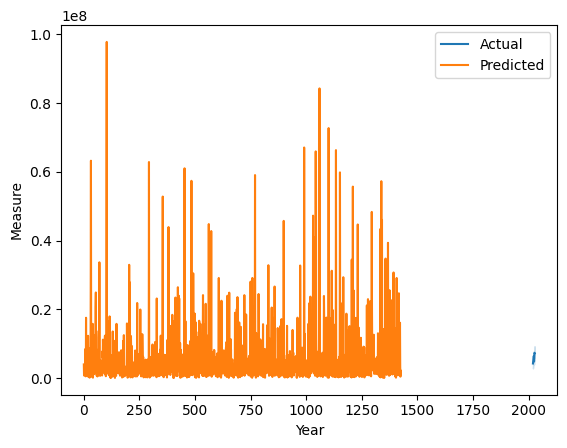

                   Model           MSE           RMSE  R2 Score
0  RandomForestRegressor  4.439272e+11  666278.641652  0.994986


In [83]:
search_term = "IndustrySegment"
model = RandomForestRegressor()
main(search_term,model)

Model for Buildings


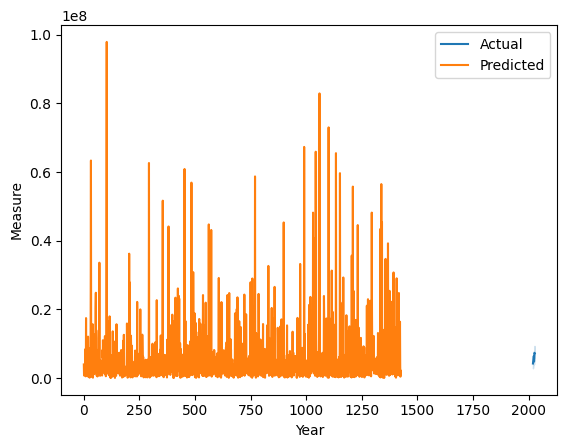

                   Model           MSE           RMSE  R2 Score
0  RandomForestRegressor  4.575696e+11  676438.898914  0.994832


In [84]:
search_term = "Buildings"
model = RandomForestRegressor()
main(search_term,model)